# Run Simulation
**Warning** This will take a long time; double check the visualisation section to see if the simulation pickles already exist. 

In [8]:
import os
import sys
import pandas as pd

os.chdir('/home/rwb/github/thesis_experiments')
sys.path.insert(0, os.path.abspath('../../thesis_experiments'))
sys.path.insert(0, os.path.abspath('../../topsim_pipelines'))
sys.path.insert(0, os.path.abspath('../../shadow'))


# Visualisation
Quick comparison between the simulation output from a previous sequence of simulations (the data used to generate ISC-HPC poster plots for 2021.). Those simulations used a re-allocation method of dynamic scheduling, rather than the updated fixed schedule approach. 

In [69]:
import pandas as pd 
# global_sim_new = pd.read_pickle('visualisation_playground/simulation_output.pkl')
# PLOTTING SIMULATION DATA - originally produced in a Jupyter Notebook
# Group by planning, delay, and config to get the simulation time for each
# simulation.
# greedy_pickle = pd.read_pickle(f"2021-07-08_global_sim_<class 'user.greedy.GreedyAlgorithmFromPlan'>.pkl")

batch_sim = pd.read_pickle('2021-08-09_global_sim_batch.pkl')
df_batch = batch_sim.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df_batch['config'] = df_batch['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
basetime = pd.Series(df_batch[df_batch['planning'] == 'batch']['time'])
basetime = basetime.append(basetime,ignore_index=True)
df_batch['increase'] = basetime/df_batch['time']
df_batch =df_batch.append(df_batch, ignore_index=True)
dynamic = ['Fixed' if x < 5 else 'Re-allocate' for x in range(10)]
df_batch['dynamic'] = dynamic

global_sim_new = pd.read_pickle('visualisation_playground/simulation_output_noreallocation.pkl')
dfnew = global_sim_new.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
dfnew['config'] = dfnew['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
# basetime = pd.Series(dfnew[dfnew['planning'] == 'fcfs']['time'])
# basetime = basetime.append(basetime,ignore_index=True)
dfnew['increase'] = basetime/dfnew['time']
dfnew['dynamic']= ['Fixed' for x in range(10)]

global_sim = pd.read_pickle('2021_isc-hpc/output/isc-hpc_simulation_output.pkl')
# Group by planning, delay, and config to get the simulation time for each
# simulation.
df = global_sim.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df['config'] = df['config'].str.replace('visualisation_playground/sim_config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
# basetime = pd.Series(df[df['planning'] == 'fcfs']['time'])
# basetime = basetime.append(basetime,ignore_index=True)
df['increase'] = basetime/df['time']
df['dynamic']= ['Re-allocate' for x in range(10)]


frames = [dfnew,df,df_batch]
total_df = pd.concat(frames, ignore_index=True)
# total_df
df_batch

,planning,delay,config,time,increase,dynamic
0,batch,0,10.0,890.0,1.0,Fixed
1,batch,0,20.0,1659.0,1.0,Fixed
2,batch,0,40.0,2886.0,1.0,Fixed
3,batch,0,60.0,4114.0,1.0,Fixed
4,batch,0,80.0,5342.0,1.0,Fixed
5,batch,0,10.0,890.0,1.0,Re-allocate
6,batch,0,20.0,1659.0,1.0,Re-allocate
7,batch,0,40.0,2886.0,1.0,Re-allocate
8,batch,0,60.0,4114.0,1.0,Re-allocate
9,batch,0,80.0,5342.0,1.0,Re-allocate


In [42]:
import matplotlib as mpl
mpl.get_cachedir()


'/home/rwb/.cache/matplotlib'

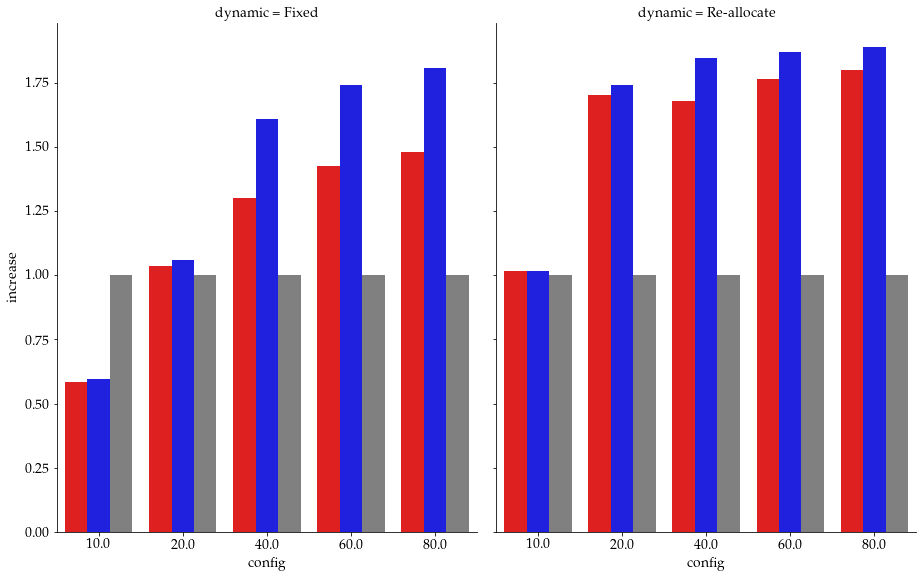

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,
    "font.family": ["serif"],
    "font.serif": ["Palatino"],
    'font.size': 14
})

# fig, ax = plt.subplots(figsize=(8,4))
plot = sns.catplot(data=total_df,x='config', y='increase', hue='planning',
                   col='dynamic',kind="bar",legend=False,palette=["red", "blue","grey"],height=8, aspect=.8)
# ax = plot.axes[0][1]
# h, l = ax.get_legend_handles_labels()
# ax.legend(h,['Batch','FCFS','HEFT'], title='Static planning strategy',loc='upper right')
# ax = plot.axes[0][0]
# ax.set_ylabel('\% Improvement on final schedule Makespan')
# ax.set_xlabel('Max Workflow Parallelism')
# ax.set(ylim=(0.9,1.3))
# fig.savefig('ratio_comparison.png', format="png")


In [75]:
dfnew = global_sim_new.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df_tasksnew = global_sim_new.groupby(['planning','delay', 'config'])['running_tasks'].mean().astype(float).reset_index(name='mean_tasks').sort_values(by=['planning'])
dfnew['config'] = dfnew['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasksnew['config'] =df_tasksnew['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasksnew['dynamic']= ['Fixed' for x in range(10)]
plotdata_new= pd.merge(dfnew, df_tasksnew, on=['planning', 'config'])


df = global_sim.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df_tasks = global_sim.groupby(['planning','delay', 'config'])['running_tasks'].mean().astype(float).reset_index(name='mean_tasks').sort_values(by=['planning'])
df['config'] = df['config'].str.replace('visualisation_playground/sim_config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasks['config'] =df_tasks['config'].str.replace('visualisation_playground/sim_config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasks['dynamic'] = ['Re-allocated' for x in range(10)]
plotdata = pd.merge(df, df_tasks, on=['planning', 'config'])

df_batch = batch_sim.groupby(['planning','delay', 'config']).size().astype(float).reset_index(name='time').sort_values(by=['planning'])
df_tasks_batch = batch_sim.groupby(['planning','delay', 'config'])['running_tasks'].mean().astype(float).reset_index(name='mean_tasks').sort_values(by=['planning'])
df_batch['config'] = df_batch['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasks_batch['config'] =df_tasks_batch['config'].str.replace('2021_isc-hpc/config/single_size/40cluster/mos_sw','').str.strip('.json').astype(float)
df_tasks_batch['dynamic']= dynamic = ['batch' for x in range(5)]
plotdata_batch = pd.merge(df_batch, df_tasks_batch, on=['planning', 'config'])
frames = [plotdata_new,plotdata,plotdata_batch]

totalplotdata = pd.concat(frames, ignore_index=True)
totalplotdata

,planning,delay_x,config,time,delay_y,mean_tasks,dynamic
0,fcfs,0,10.0,1523.0,0,9.223900,Fixed
1,fcfs,0,20.0,1603.0,0,16.224579,Fixed
2,fcfs,0,40.0,2219.0,0,22.500225,Fixed
3,fcfs,0,60.0,2885.0,0,25.597227,Fixed
4,fcfs,0,80.0,3610.0,0,27.082548,Fixed
5,heft,0,10.0,1496.0,0,9.390374,Fixed
6,heft,0,20.0,1564.0,0,16.629156,Fixed
7,heft,0,40.0,1792.0,0,27.861607,Fixed
8,heft,0,60.0,2361.0,0,31.278272,Fixed
9,heft,0,80.0,2957.0,0,33.063240,Fixed


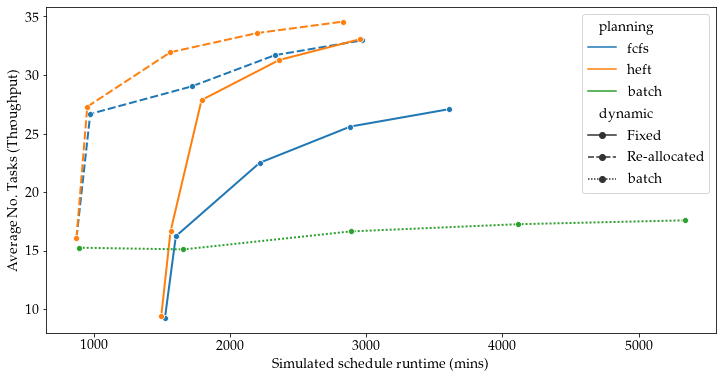

In [77]:
fig, ax = plt.subplots(figsize=(12,6))
# plotdata = pd.merge(df, df_tasks, on=['planning', 'config'])
sns.lineplot(data=totalplotdata,x='time', y='mean_tasks',hue='planning',axes=ax,linewidth = 2,
            markers=['o','o','o'],style='dynamic')
ax.set_ylabel('Average No. Tasks (Throughput)')
ax.set_xlabel('Simulated schedule runtime (mins)')
# ax.legend(title='Static planning strategy',labels=['FCFS','HEFT'],loc='center right')
plt.show()
# fig.savefig('tasks_throughput.svg', format="svg")
plt.show()

By doing multiw-workflow, we are optimising all workflows, not just single workflows
    * single workflows may take longer, overall plan takes less time 
    
Main goal for the thesis is science throughput 